# Face Detection

Hello! In this task we will create our own deep face detector.

First of all, we need import some useful stuff.

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Of course, also we should install `keras`, `matplotlib`, `numpy` and `scikit-image`.

In [2]:
import time
import datetime
from datetime import date
from get_data import load_dataset, unpack
from matplotlib import pyplot as plt
import numpy as np
import os.path
from skimage import transform
from skimage.feature import peak_local_max
from graph import show_bboxes, visualize_bboxes, visualize_samples, visualize_heatmap, plot_history, plot_precision_recall
from scores import iou_score, best_match # https://en.wikipedia.org/wiki/Jaccard_index
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator # Usefull thing. Read the doc.
from keras.optimizers import SGD, Adam
# Very usefull, pay attention
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Activation, Input, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, ReLU, LeakyReLU, Softmax, GlobalAveragePooling2D

In this task we use processed [FDDB dataset](http://vis-www.cs.umass.edu/fddb/). Processing defined in file [./prepare_data.ipynb](prepare_data.ipynb) and consists of:

1. Extract bboxes from dataset. In base dataset face defined by [ellipsis](http://vis-www.cs.umass.edu/fddb/samples/) that not very useful for basic neural network learning.
2. Remove images with big and small faces on one shoot.
3. Re-size images to bounding boxes (bboxes) have same size 32 +/- pixels.

Each image in train, validation and test datasets have shape (176, 176, 3), but part of this image is black background. Interesting image aligned at top left corner.

Bounding boxes define face in image and consist of 5 integer numbers: [image_index, min_row, min_col, max_row, max_col]. Bounding box width and height are 32 +/- 8 pixels wide.

`train_bboxes` and `val_bboxes` is a list of bboxes.

`train_shapes` and `val_shapes` is a list of interesting image shapes.

In [3]:
# First run will download 30 MB data from github
train_images, train_bboxes, train_shapes = load_dataset("data", "train")
val_images, val_bboxes, val_shapes = load_dataset("data", "val")

In [4]:
np.stack(train_images[x].shape for x in range(10))

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


array([[176, 176,   3],
       [176, 176,   3],
       [176, 176,   3],
       [176, 176,   3],
       [176, 176,   3],
       [176, 176,   3],
       [176, 176,   3],
       [176, 176,   3],
       [176, 176,   3],
       [176, 176,   3]])

In [5]:
np.stack(val_images[x].shape for x in range(10))

array([[176, 176,   3],
       [176, 176,   3],
       [176, 176,   3],
       [176, 176,   3],
       [176, 176,   3],
       [176, 176,   3],
       [176, 176,   3],
       [176, 176,   3],
       [176, 176,   3],
       [176, 176,   3]])

In [6]:
print(len(train_images))
print(len(train_bboxes))
print(len(train_shapes))

918
1051
918


In [7]:
train_bboxes[:10,0]

array([0, 1, 2, 3, 3, 4, 5, 6, 6, 7], dtype=int32)

In [8]:
np.stack(train_bboxes[:10])

array([[  0,   6,  27,  42,  54],
       [  1,   9,  42,  47,  68],
       [  2,   8,  38,  46,  63],
       [  3,  10,  13,  47,  38],
       [  3,  30,  95,  69, 121],
       [  4,  11,  26,  50,  51],
       [  5,   3,  32,  41,  58],
       [  6,   0,  14,  37,  45],
       [  6,   4,  60,  40,  84],
       [  7,   4,  28,  39,  55]], dtype=int32)

In [9]:
np.stack(train_shapes[:10])

array([[ 65,  68],
       [ 97,  97],
       [157, 129],
       [ 99, 132],
       [ 92,  79],
       [138,  90],
       [ 66,  93],
       [ 86, 132],
       [ 89, 107],
       [115,  95]], dtype=int32)

In [10]:
print(len(val_images))
print(len(val_bboxes))
print(len(val_shapes))

306
357
306


In [11]:
val_bboxes[:10,0]

array([0, 0, 0, 1, 2, 3, 4, 5, 6, 6], dtype=int32)

In [12]:
np.stack(val_bboxes[:10])

array([[  0,  18,  10,  51,  38],
       [  0,   3,  39,  43,  64],
       [  0,  26,  63,  58,  97],
       [  1,   5,  31,  43,  57],
       [  2,   6,  16,  44,  41],
       [  3,  10,  53,  49,  78],
       [  4,   5,  20,  45,  44],
       [  5,  66,  55, 103,  81],
       [  6,   4,  36,  44,  61],
       [  6,  20,  96,  58, 121]], dtype=int32)

In [13]:
np.stack(val_shapes[:10])

array([[ 64, 108],
       [102,  79],
       [ 69,  96],
       [135, 110],
       [100,  66],
       [167, 132],
       [120, 151],
       [103, 128],
       [ 94, 119],
       [ 60,  40]], dtype=int32)

## Prepare data

For learning we should extract positive and negative samples from image.
Positive and negative samples counts should be similar.
Every samples should have same size.

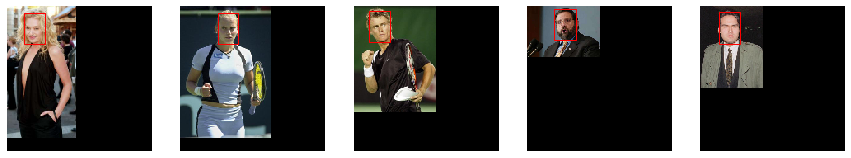

In [14]:
visualize_bboxes(images=train_images,true_bboxes=train_bboxes)

Every image can represent multiple faces, so we should extract all faces from every images and crop them to `SAMPLE_SHAPE`. This set of extracted images are named `positive`.

Then we chould extract `negative` set. This images should have `SAMPLE_SHAPE` size. Pseudocode for extracting:

    negative_collection := []

    for i in range(negative_bbox_count):
        Select random image.
        image_shape := image_shapes[image_index]
        image_true_bboxes := true_bboxes[true_bboxes[:, 0] == image_index, 1:]
        
        for j in TRY_COUNT: # TRY_COUNT is a magic constant, for example, 100
            Generate new_bbox within image_shape.
            
            if new_bbox is negative bbox for image_true_bboxes:
                Extract from image, new_bbox and resize to SAMPLE_SIZE negative_sample.
                Add negative sample to negative_collection.
                Break # for j in TRY_COUNT

In [15]:
SAMPLE_SHAPE = (32, 32, 3)

In [16]:
def is_negative_bbox(new_bbox, true_bboxes, eps=1e-1):
    """Check if new bbox not in true bbox list.
    
    There bbox is 4 ints [min_row, min_col, max_row, max_col] without image index."""
    for bbox in true_bboxes:
        if iou_score(new_bbox, bbox) >= eps:
            return False
    return True

In [17]:
def gen_negative_bbox(image_shape, bbox_size, true_bboxes):
    """Generate negative bbox for image."""
    TRY_COUNT = 1000
    for i in range(TRY_COUNT):
        min_row = np.random.randint(max(image_shape[0]-bbox_size,1))
        min_col = np.random.randint(max(image_shape[1]-bbox_size,1))
        new_bbox = [min_row, min_col, min_row+bbox_size, min_col+bbox_size]
        
        if is_negative_bbox(new_bbox, true_bboxes):
            return new_bbox
    
    return None 

In [18]:
def get_crop(true_bbox):
    
    x_size = true_bbox[2] - true_bbox[0]
    y_size = true_bbox[3] - true_bbox[1]
    cloned_bbox = np.copy(true_bbox)
    
    # from rectangular to square
    
    if x_size==y_size:
        return true_bbox
    
    elif x_size>y_size:
        diff = x_size - y_size
        cloned_bbox[1] = max(true_bbox[1] - diff,0) 
        cloned_bbox[3] = cloned_bbox[1] + x_size
    else:
        diff = y_size - x_size
        cloned_bbox[0] = max(true_bbox[0] - diff,0)
        cloned_bbox[2] = cloned_bbox[0] + y_size
        
    return cloned_bbox

In [19]:
def get_positive_negative(images, true_bboxes, image_shapes, negative_bbox_count=None):
    """Retrieve positive and negative samples from image."""
    positive = []
    negative = []
    image_count = image_shapes.shape[0]
    side = SAMPLE_SHAPE[0]
    
    if negative_bbox_count is None:
        negative_bbox_count = len(true_bboxes)
    
    # Pay attention to the fact that most part of image may be black -
    # extract negative samples only from part [0:image_shape[0], 0:image_shape[1]]
    
    for i in range(negative_bbox_count):
        image_index = np.random.randint(image_count)
        image_shape = image_shapes[image_index]
        image_true_bboxes = true_bboxes[true_bboxes[:,0] == image_index, 1:]
        bbox_size = np.random.randint(25,50)
        
        if image_shape[0]<bbox_size or image_shape[1]<bbox_size:
            bbox_size = min(image_shape[0],min(image_shape[1],32))
            
        neg_bbox = gen_negative_bbox(image_shape, bbox_size, image_true_bboxes)
        if neg_bbox is not None:
            negative.append(transform.resize(images[image_index][neg_bbox[0]:neg_bbox[2],neg_bbox[1]:neg_bbox[3]],
                                                                                     (side,side)))
        
        pos_bbox = get_crop(true_bboxes[i][1:])
        positive.append(transform.resize(images[true_bboxes[i][0]][pos_bbox[0]:pos_bbox[2],pos_bbox[1]:pos_bbox[3]],
                                                                                     (side,side)))
        
    return positive, negative

In [20]:
def get_samples(images, true_bboxes, image_shapes):
    """Usefull samples for learning.
    
    X - positive and negative samples.
    Y - one hot encoded list of zeros and ones. One is positive marker.
    """
    positive, negative = get_positive_negative(images=images, true_bboxes=true_bboxes, image_shapes=image_shapes)
    X = positive
    Y = [[0, 1]] * len(positive)
    
    X.extend(negative)
    Y.extend([[1, 0]] * len(negative))
    
    return np.array(X), np.array(Y)

Now we can extract samples from images.

In [21]:
X_train, Y_train = get_samples(train_images, train_bboxes, train_shapes)
X_val, Y_val = get_samples(val_images, val_bboxes, val_shapes)

In [22]:
print(len(train_images),len(train_bboxes),len(train_shapes))
print(X_train.shape,Y_train.shape)

918 1051 918
(1916, 32, 32, 3) (1916, 2)


In [23]:
print(len(val_images),len(val_bboxes),len(val_shapes.shape))
print(X_val.shape,Y_val.shape)

306 357 2
(652, 32, 32, 3) (652, 2)


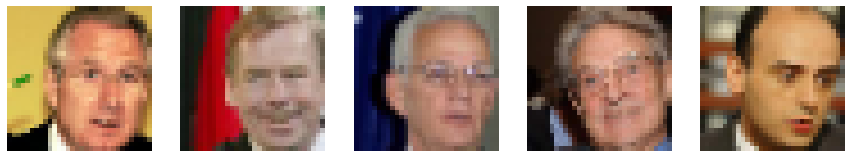

In [24]:
# There we should see faces
visualize_samples(X_train[Y_train[:, 1] == 1])

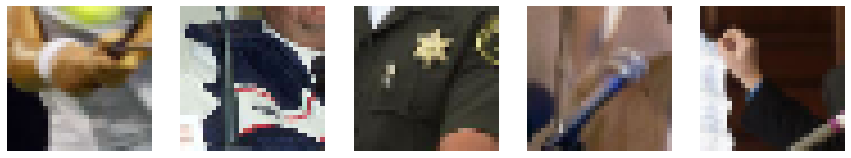

In [25]:
# There we shouldn't see faces
visualize_samples(X_train[Y_train[:, 1] == 0])

## Classifier training

First of all, we should train face classifier that checks if face represented on sample.

In [26]:
BATCH_SIZE = 64

### Image augmentation

Important thing in deep learning is augmentation. Sometimes, if our model is complex and cool, we can increase quality by using good augmentation.

In [27]:
datagen = ImageDataGenerator(horizontal_flip=True,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.1,
                            )
datagen.fit(X_train)

### Fitting classifier

For fitting you can use one of Keras optimizer algorithms. To choose the best learning rate strategy we should consider EarlyStopping, ReduceLROnPlateau and/or LearningRateScheduler on keras [callbacks](https://keras.io/callbacks/), which is very useful in deep learning.

In [28]:
def fit(model, datagen, X_train, Y_train, X_val, Y_val, model_name=None, output_dir="data/checkpoints", 
        class_weight=None, epochs=100, lr=0.001, verbose=False):
    """Fit model."""
    
    if verbose:
        model.summary()

    model.compile(optimizer=Adam(lr=lr), # You can use another optimizer
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    
    history = model.fit(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
                        validation_data=(datagen.standardize(X_val), Y_val),
                        epochs=epochs, steps_per_epoch=len(X_train) // BATCH_SIZE,
                        callbacks=[ModelCheckpoint(os.path.join(output_dir, "{model_name}").format(model_name=model_name) + '-{epoch:02d}-{val_loss:.2f}-'+str(date.today())+'.hdf5', 
                                                   save_best_only=True)] if model_name is not None else [],
                        class_weight=class_weight) # starts training
    
    plot_history(history)

#### Transfer learning - pre-trained model

![lenet architecture](lenet_architecture.png)
LeCun, Y., Bottou, L., Bengio, Y. and Haffner, P., 1998. Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11), pp.2278-2324.

Of course, besides `lenet`, any other architectures are also okay, as long as the classification quality is acceptable. 

In [29]:
def generate_model(sample_shape):
    # Classification model
    # You can start from LeNet architecture
    x = inputs = Input(shape=sample_shape)

    ###########################################

    x=Conv2D(32, (3, 3), padding='same')(inputs)
    #x=BatchNormalization()(x)
    x=ReLU()(x)

    x=MaxPooling2D((2, 2), padding='same')(x)
    
    ###########################################

    x=Conv2D(64, (3, 3), padding='same')(x)
    #x=BatchNormalization()(x)
    x=ReLU()(x)

    x=MaxPooling2D((2, 2), padding='same')(x)
    
    ###########################################

    x=Flatten()(x)

    x=Dense(128)(x)
    #x=BatchNormalization()(x)
    x=ReLU()(x)
    x=Dropout(0.35)(x)

    x=Dense(64)(x)
    #x=BatchNormalization()(x)
    x=ReLU()(x)
    x=Dropout(0.35)(x)

    # This creates a model
    connected=Dense(2)(x)
    predictions=Softmax()(connected) 
    return Model(inputs=inputs, outputs=predictions)

In [30]:
model = generate_model(SAMPLE_SHAPE)

In [31]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
re_lu (ReLU)                 (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)         

#### Fit the model 

We can first check neural network modifications with small value of parameter `epochs`, for example, 10, and then we increase this parameter after selecting best model fitting parameters.

In [32]:
X_train = X_train.astype('float64')
X_val = X_val.astype('float64')

In [33]:
print(X_train[1].shape)
print(Y_train[1200])

(32, 32, 3)
[1 0]


Epoch 1/100
29/29 [==============================] - 7s 233ms/step - loss: 0.6297 - accuracy: 0.6501 - val_loss: 0.4290 - val_accuracy: 0.8313
Epoch 2/100
29/29 [==============================] - 7s 255ms/step - loss: 0.4749 - accuracy: 0.7997 - val_loss: 0.3209 - val_accuracy: 0.8712
Epoch 3/100
29/29 [==============================] - 8s 269ms/step - loss: 0.4021 - accuracy: 0.8369 - val_loss: 0.2559 - val_accuracy: 0.8926
Epoch 4/100
29/29 [==============================] - 9s 294ms/step - loss: 0.3489 - accuracy: 0.8618 - val_loss: 0.2067 - val_accuracy: 0.9187
Epoch 5/100
29/29 [==============================] - 9s 298ms/step - loss: 0.3251 - accuracy: 0.8699 - val_loss: 0.2073 - val_accuracy: 0.9187
Epoch 6/100
29/29 [==============================] - 9s 315ms/step - loss: 0.3127 - accuracy: 0.8699 - val_loss: 0.2260 - val_accuracy: 0.9248
Epoch 7/100
29/29 [==============================] - 9s 320ms/step - loss: 0.2813 - accuracy: 0.8936 - val_loss: 0.1738 - val_accuracy: 0.9294

Epoch 58/100
29/29 [==============================] - 9s 308ms/step - loss: 0.0799 - accuracy: 0.9698 - val_loss: 0.0676 - val_accuracy: 0.9663
Epoch 59/100
29/29 [==============================] - 9s 306ms/step - loss: 0.0816 - accuracy: 0.9703 - val_loss: 0.0699 - val_accuracy: 0.9724
Epoch 60/100
29/29 [==============================] - 9s 304ms/step - loss: 0.0742 - accuracy: 0.9714 - val_loss: 0.0893 - val_accuracy: 0.9678
Epoch 61/100
29/29 [==============================] - 10s 330ms/step - loss: 0.0869 - accuracy: 0.9692 - val_loss: 0.0691 - val_accuracy: 0.9770
Epoch 62/100
29/29 [==============================] - 9s 307ms/step - loss: 0.0713 - accuracy: 0.9725 - val_loss: 0.0725 - val_accuracy: 0.9678
Epoch 63/100
29/29 [==============================] - 9s 307ms/step - loss: 0.0794 - accuracy: 0.9757 - val_loss: 0.0646 - val_accuracy: 0.9770
Epoch 64/100
29/29 [==============================] - 9s 313ms/step - loss: 0.0644 - accuracy: 0.9752 - val_loss: 0.0965 - val_accuracy

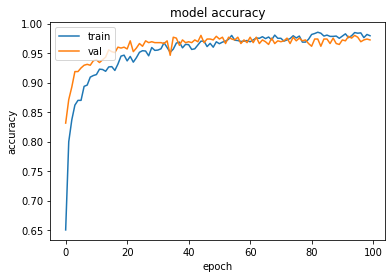

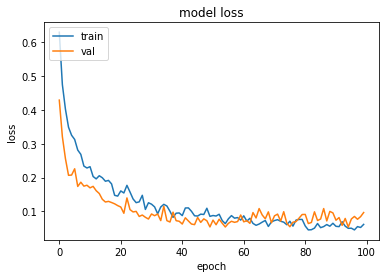

In [34]:
# Attention: Windows implementation may cause an error here. In that case use model_name=None.
fit(model_name="myFaceTrain", model=model, datagen=datagen, 
    X_train=X_train, X_val=X_val, 
    Y_train=Y_train, Y_val=Y_val)

#### Save outputs

After the completion of learning model, all weights are saved in folder `data/checkpoints/`.
Use `model.load_weights(fname)` to load best weights.

In [35]:
def get_checkpoint():
    return 'data/checkpoints/myFaceTrain-66-0.06-'+str(date.today())+'.hdf5'

In [36]:
model.load_weights(get_checkpoint())

In [37]:
results_train = model.evaluate(X_train, Y_train)

60/60 [==============================] - 2s 27ms/step - loss: 0.0504 - accuracy: 0.9849


In [38]:
results_val = model.evaluate(X_val, Y_val)

21/21 [==============================] - 1s 29ms/step - loss: 0.0570 - accuracy: 0.9785


--- 10.05.2020

## Detection

If one classification architecture with high validation score has been prepared, we can use this architecture for detection.

Convert classification architecture to fully convolution neural network (FCNN), that returns heatmap of activation.

### Detector model or sliding window 

Now we should replace fully-connected layers with $1 \times 1$ convolution layers.

Every fully connected layer perform operation $f(Wx + b)$, where $f(\cdot)$ is nonlinear activation function, $x$ is layer input, $W$ and $b$ is layer weights. This operation can be emulated with $1 \times 1$ convolution with activation function $f(\cdot)$, that perform exactly same operation $f(Wx + b)$.

If there is `Flatten` layer with $n \times k$ input size before fully connected layers, convolution should have same $n \times k$ input size. Multiple fully connected layers can be replaced with convolution layers sequence.

After replacing all fully connected layers with convolution layers, we get fully convolution network. If input shape is equal to input size of previous network, output will have size $1 \times 1$. But if we increase input shape, output shape automatically will be increased. For example, if convolution step of previous network strides 4 pixels, increasing input size with 100 pixels along all axis makes increment of output size with 25 values along all axis. We got activation map of classifier without necessarily extracting samples from image and calculating low-level features multiple times.

In total:
1. $1 \times 1$ convolution layer is equivalent of fully connected layer.
2. $1 \times 1$ convolution layers can be used to get activation map of classification network in "sliding window" manner.

We propose replace last fully connected layer with softmax actiovation to convolution layer with linear activation. It will be usefull to find good threshold. Of course, we can use `softmax` activation.

#### Example of replace cnn head:

##### Head before convert

![before replace image](before_convert.png)

##### Head after convert

![before replace image](after_convert.png)

On this images displayed only head. `InputLayer` should be replaced with convolution part exit.
Before convert network head takes fifty $8 \times 8$ feature maps and returns two values: probability of negative and positive classes. This output can be considered as activation map with size $1 \times 1$.

If the input has size $8 \times 8$, output after convert would have $1 \times 1$ size, but input size is $44 \times 44$. After convert network head returns one $37 \times 37$ activation map.

In [39]:
# FCNN
IMAGE_SHAPE = (176, 176, 3)

In [40]:
def generate_fcnn_model(image_shape):
    """After model compilation input size cannot be changed.
    
    So, we need create a function to have ability to change size later.
    """
    x = inputs = Input(image_shape)

    ###########################################

    x=Conv2D(32, (3, 3), padding='same')(inputs)
    #x=BatchNormalization()(x)
    x=ReLU()(x)

    x=MaxPooling2D((2, 2), padding='same')(x)
    
    ###########################################

    x=Conv2D(64, (3, 3), padding='same')(x)
    #x=BatchNormalization()(x)
    x=ReLU()(x)

    x=MaxPooling2D((2, 2), padding='same')(x)
    
    ###########################################
    
    x=Conv2D(128, (8, 8))(x)
    #x=BatchNormalization()(x)
    x=ReLU()(x)
    x=Dropout(0.35)(x)

    ###########################################
    
    x=Conv2D(64, (1, 1))(x)
    #x=BatchNormalization()(x)
    x=ReLU()(x)
    x=Dropout(0.35)(x)
    
    # This creates a model
    predictions=Conv2D(2, (1,1), activation='linear')(x)
    return Model(inputs=inputs, outputs=predictions)

In [41]:
fcnn_model = generate_fcnn_model(IMAGE_SHAPE)

In [42]:
fcnn_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 176, 176, 3)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 176, 176, 32)      896       
_________________________________________________________________
re_lu_4 (ReLU)               (None, 176, 176, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 88, 88, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 88, 88, 64)        18496     
_________________________________________________________________
re_lu_5 (ReLU)               (None, 88, 88, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 44, 44, 64)       

#### Weight transferred from fully `connected` layers to fully `convolution` layers

Then we should write function that copy weights from classification model to fully convolution model. Convolution weights may be obtained from copy without modification, fully-connected layer weights should be reshaped before being copied.

In [43]:
def copy_weights(base_model, fcnn_model):
    
    """Set FCNN weights from base model.
    """
    
    new_fcnn_weights = []
    prev_fcnn_weights = fcnn_model.get_weights()
    prev_base_weights = base_model.get_weights()
    
    for i in range(len(prev_fcnn_weights)):
        print(i,prev_fcnn_weights[i].shape,prev_base_weights[i].shape)
        new_fcnn_weights.append(prev_base_weights[i].reshape(prev_fcnn_weights[i].shape))
        
    fcnn_model.set_weights(new_fcnn_weights)

In [44]:
copy_weights(base_model=model, fcnn_model=fcnn_model)

0 (3, 3, 3, 32) (3, 3, 3, 32)
1 (32,) (32,)
2 (3, 3, 32, 64) (3, 3, 32, 64)
3 (64,) (64,)
4 (8, 8, 64, 128) (4096, 128)
5 (128,) (128,)
6 (1, 1, 128, 64) (128, 64)
7 (64,) (64,)
8 (1, 1, 64, 2) (64, 2)
9 (2,) (2,)


### Model visualization

In [45]:
predictions = fcnn_model.predict(np.array(datagen.standardize(val_images)))

In [46]:
predictions.shape

(306, 37, 37, 2)

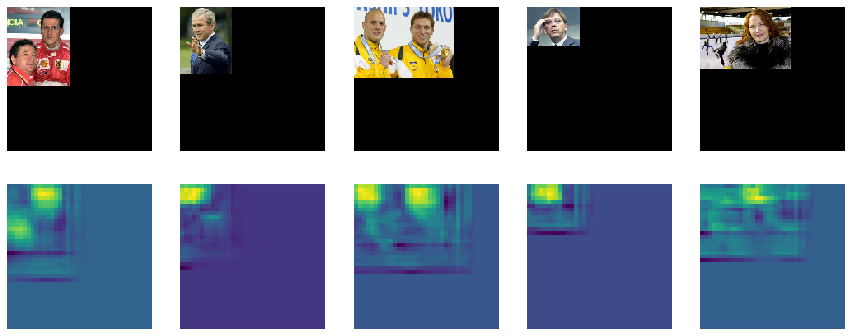

In [47]:
visualize_heatmap(val_images[100:1000], predictions[100:1000, :, :, 1])

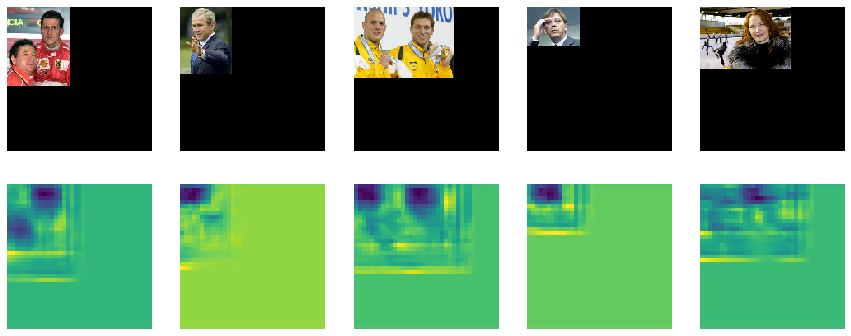

In [48]:
visualize_heatmap(val_images[100:1000], predictions[100:1000, :, :, 0])

### Detector

First detector part is getting bboxes and decision function.
Greater decision function indicates better detector confidence.

This function should return pred_bboxes and decision_function:

- `pred bboxes` is list of 5 int tuples like `true bboxes`: `[image_index, min_row, min_col, max_row, max_col]`.
- `decision function` is confidence of detector for every pred bbox: list of float values, `len(decision function) == len(pred bboxes)` 
 
We propose resize image to `IMAGE_SHAPE` size, find faces on resized image with `SAMPLE_SHAPE` size and then resize them back.

In [49]:
# Detection
def get_bboxes_and_decision_function(fcnn_model, images, image_shapes):      
    cropped_images = np.array([transform.resize(image, IMAGE_SHAPE, mode="reflect") if image.shape != IMAGE_SHAPE else image for image in images])
    pred_bboxes, decision_function = [], []
   
    # Predict
    predictions = fcnn_model.predict(datagen.standardize(np.asarray(cropped_images,dtype='float')))
    
    for i in range(len(predictions)):
        img_shape = image_shapes[i]
        local_max_list = peak_local_max(predictions[i][:,:,1], num_peaks=5, min_distance=3, exclude_border=False)
        for local_max_orig in local_max_list:
            local_max = np.asarray(local_max_orig*175.0/37,dtype='int')
            
            if local_max[0]>=img_shape[0] or local_max[1]>=img_shape[1]:
                continue
            else:
                bbox = [local_max[0]-16,local_max[1]-16,local_max[0]+16,local_max[1]+16]
                if bbox[0]<0:
                    bbox[0]=0
                    bbox[2]=32
                if bbox[1]<0:
                    bbox[1]=0
                    bbox[3]=32
                if bbox[2]>=img_shape[0]:
                    bbox[2]=img_shape[0]-1
                    bbox[0]=bbox[2]-32
                if bbox[3]>=img_shape[1]:
                    bbox[3]=img_shape[1]-1
                    bbox[1]=bbox[3]-32
                
                pred_bboxes.append([i]+bbox)
                decision_function.append(predictions[i][local_max_orig[0],local_max_orig[1],1])
        
    return pred_bboxes, decision_function

#### Detector visualization

In [50]:
num = 10
pred_bboxes, decision_function = get_bboxes_and_decision_function(fcnn_model=fcnn_model,images=val_images[:num],
                                                                  image_shapes=val_shapes[:num])

In [51]:
pred_bboxes, decision_function = get_bboxes_and_decision_function(fcnn_model=fcnn_model,images=val_images[:],
                                                                  image_shapes=val_shapes[:])

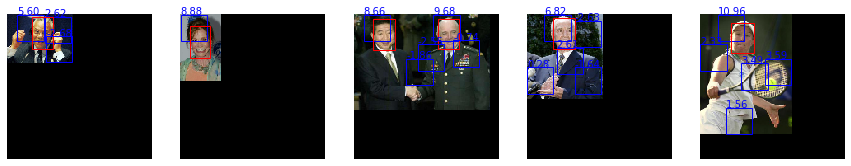

In [52]:
visualize_bboxes(images=val_images,
                 pred_bboxes=pred_bboxes,
                 true_bboxes=val_bboxes,
                 decision_function=decision_function
                )

In [53]:
def visualize_bboxes1(images, pred_bboxes=None, true_bboxes=None, decision_function=None, n_cols=5, n_rows=1):
    plt.figure(figsize = (3*n_cols,3*n_rows))
    
    if pred_bboxes is not None:
        pred_bboxes = np.array(pred_bboxes, dtype=np.int32)
    if true_bboxes is not None:
        true_bboxes = np.array(true_bboxes, dtype=np.int32)

    for n,i in enumerate(range(5)):
        ax = plt.subplot(n_rows,n_cols,n+1)
        plt.axis('off')
        plt.imshow(images[i])

        if pred_bboxes is not None:
            _text = (["{0:0.2f}".format(decision_function[prec]) for prec in np.where(pred_bboxes[:, 0] == i)[0]]
                     if decision_function is not None else None)
            show_bboxes(bboxes=pred_bboxes[pred_bboxes[:, 0] == i, 1:], ax=ax, color="blue", text=_text)
        
        if true_bboxes is not None:
            show_bboxes(bboxes=true_bboxes[true_bboxes[:, 0] == i, 1:], ax=ax, color="red")
    plt.show()

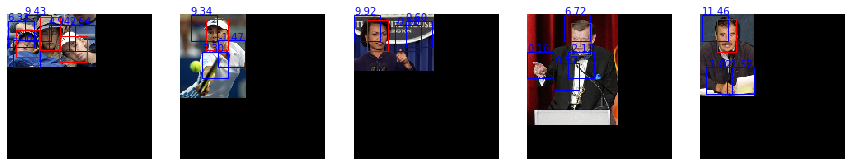

In [54]:
visualize_bboxes1(images=val_images,
                  pred_bboxes=pred_bboxes,
                  true_bboxes=val_bboxes,
                  decision_function=decision_function
                 )

## Detector score 

We can use function `best_match` to extract matching between prediction and ground truth, false positive and false negative samples. Pseudo-code for calculation precision and recall graph:
    
    # Initialization for first step threshold := -inf
    tn := 0 # We haven't any negative sample
    fn := |false_negative| # But some faces wasn't been detected
    tp := |true_bboxes| # All true bboxes have been caught
    fp := |false_positive| # But also some false positive samples have been caught
    
    Sort decision_function and pred_bboxes with order defined by decision_function
    y_true := List of answers for "Is the bbox have matching in y_true?" for every bbox in pred_bboxes
    
    for y_on_this_step in y_true:
        # Now we increase threshold, so some predicted bboxes makes negative.
        # If y_t is True then the bbox is true positive else bbox is false positive
        # So we should
        Update tp, tn, fp, fn with attention to y_on_this_step
        
        Add precision and recall point calculated by formula through tp, tn, fp, fn on this step
        Threshold for this point is decision function on this step.

In [55]:
def precision_recall_curve(pred_bboxes, true_bboxes, decision_function):
    precision, recall, thresholds = [], [], []
    
    total_pos = len(true_bboxes)
    threshold = min(decision_function)-1
    max_threshold = max(decision_function)+1
    num_steps = 1000
    delta_threshold = (max_threshold - threshold)/num_steps
    
    print(decision_function[:5])
    print(pred_bboxes[:5])

    sorted_boxes = [[x]+y for y,x in sorted(zip(pred_bboxes,decision_function),key=lambda pair:pair[1])]
    print(sorted_boxes[:5])
    
    y_true = []
    for step in range(num_steps):
        
        pred_bboxes_th = [x[1:] for x in sorted_boxes if x[0]>threshold]
        if len(pred_bboxes_th)>0:
            matched, false_negative, false_positive = best_match(pred_bboxes_th, true_bboxes, decision_function)
        else:
            break
        
        prec = len(matched)/(len(matched)+len(false_positive))
        rec = len(matched)/(len(matched)+len(false_negative))
        
        thresholds.append(threshold)
        recall.append(rec)
        precision.append(prec)
        if step%50==0:
            print(step,threshold,prec,rec)
        threshold += delta_threshold
    
    return precision, recall, thresholds

In [56]:
precision, recall, thresholds = precision_recall_curve(pred_bboxes=pred_bboxes, true_bboxes=val_bboxes, decision_function=decision_function)

[9.427276, 6.3270526, 4.9377913, 2.536084, -1.8236239]
[[0, 0, 21, 32, 53], [0, 7, 0, 39, 32], [0, 12, 50, 44, 82], [0, 12, 75, 44, 107], [0, 31, 7, 63, 39]]
[[-4.654346, 62, 40, 24, 72, 56], [-4.618602, 10, 34, 0, 66, 32], [-4.6000366, 141, 97, 111, 129, 143], [-4.4519496, 132, 57, 7, 89, 39], [-4.3819, 10, 34, 22, 66, 54]]
0 -5.654345989227295 0.3292910447761194 0.988795518207283
50 -4.513112473487869 0.33115060804490176 0.9915966386554622
100 -3.3718789577484305 0.33942307692307694 0.988795518207283
150 -2.2306454420089823 0.3607399794450154 0.9831932773109243
200 -1.089411926269543 0.4088269454123113 0.9859943977591037
250 0.0518215894698983 0.46808510638297873 0.9859943977591037
300 1.1930551052093392 0.5508607198748043 0.9859943977591037
350 2.3342886209487794 0.6717850287907869 0.9803921568627451
400 3.4755221366882276 0.8023529411764706 0.9551820728291317
450 4.616755652427663 0.9209039548022598 0.9131652661064426
500 5.757989168167089 0.9644012944983819 0.834733893557423
550 6

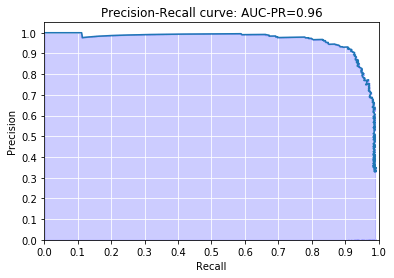

In [57]:
plot_precision_recall(precision=precision, recall=recall)

### Threshold 

Next step in detector creating is select threshold for decision_function.
Every possible threshold presents point on recall-precision graph.

Select threshold for `recall=0.85`.

In [58]:
def get_threshold(thresholds, recall):
    return thresholds[np.argmax(np.asarray(recall)<=0.85)]

In [59]:
THRESHOLD = get_threshold(thresholds, recall)
print(THRESHOLD,precision[np.argmax(np.asarray(recall)<=0.85)],recall[np.argmax(np.asarray(recall)<=0.85)])

5.415619113445262 0.946875 0.8487394957983193


In [60]:
def detect(fcnn_model, images, image_shapes, threshold, return_decision=True):
    """Get bboxes with decision_function not less then threshold."""
    pred_bboxes, decision_function = get_bboxes_and_decision_function(fcnn_model, images, image_shapes)   
    result, result_decision = [], []
    
    for i in range(len(pred_bboxes)):
        if decision_function[i]>=threshold:
            result.append(pred_bboxes[i])
            result_decision.append(decision_function[i])
    
    if return_decision:
        return result, result_decision
    else:
        return result

In [61]:
pred_bboxes, decision_function = detect(fcnn_model=fcnn_model, images=val_images, image_shapes=val_shapes, 
                                        threshold=THRESHOLD, return_decision=True)

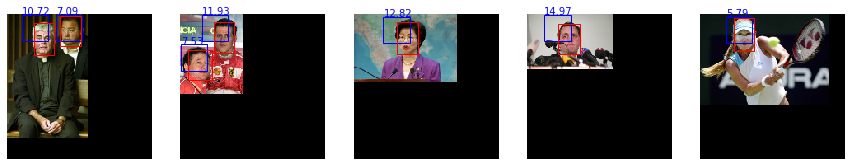

In [62]:
visualize_bboxes(images=val_images,
                 pred_bboxes=pred_bboxes,
                 true_bboxes=val_bboxes,
                 decision_function=decision_function
                )

In [63]:
precision, recall, thresholds = precision_recall_curve(pred_bboxes=pred_bboxes, true_bboxes=val_bboxes, 
                                                       decision_function=decision_function)

[9.427276, 6.3270526, 9.3376665, 9.916052, 6.7193613]
[[0, 0, 21, 32, 53], [0, 7, 0, 39, 32], [1, 0, 12, 32, 44], [2, 0, 0, 32, 32], [3, 0, 45, 32, 77]]
[[5.4525766, 116, 31, 111, 63, 143], [5.4529066, 34, 17, 12, 49, 44], [5.5065355, 117, 7, 50, 39, 82], [5.599265, 219, 0, 12, 32, 44], [5.5995026, 247, 2, 2, 34, 34]]
0 4.452576637268066 0.946875 0.8487394957983193
50 5.088464021682757 0.946875 0.8487394957983193
100 5.724351406097448 0.9612903225806452 0.834733893557423
150 6.360238790512138 0.9725085910652921 0.7927170868347339
200 6.996126174926829 0.9801587301587301 0.6918767507002801
250 7.6320135593415195 0.9951690821256038 0.5770308123249299
300 8.26790094375621 0.994413407821229 0.49859943977591037
350 8.9037883281709 0.9933774834437086 0.42016806722689076
400 9.539675712585591 0.990909090909091 0.30532212885154064
450 10.175563097000282 0.9875 0.22128851540616246
500 10.811450481414973 0.9827586206896551 0.15966386554621848
550 11.447337865829663 0.9777777777777777 0.123249299

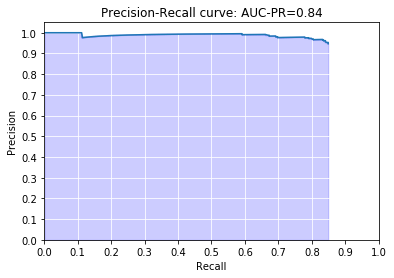

In [64]:
plot_precision_recall(precision=precision, recall=recall)

## Test dataset 

Last detector preparation step is testing.

In [65]:
test_images, test_bboxes, test_shapes = load_dataset("data", "test")

In [66]:
# We test get_bboxes_and_decision_function becouse we want pay attention to all recall values
pred_bboxes, decision_function = get_bboxes_and_decision_function(fcnn_model=fcnn_model, images=test_images, 
                                                                  image_shapes=test_shapes)

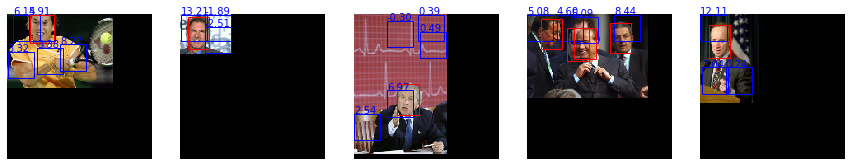

In [67]:
visualize_bboxes(images=test_images,
                 pred_bboxes=pred_bboxes,
                 true_bboxes=test_bboxes,
                 decision_function=decision_function
                )

In [68]:
precision, recall, threshold = precision_recall_curve(pred_bboxes=pred_bboxes, true_bboxes=test_bboxes, 
                                                      decision_function=decision_function)

[7.273536, 3.5862715, 0.97329265, 7.3855515, -3.8942344]
[[0, 2, 0, 34, 32], [0, 40, 0, 72, 32], [0, 40, 21, 72, 53], [1, 0, 0, 32, 32], [1, 34, 17, 66, 49]]
[[-4.707982, 12, 30, 11, 62, 43], [-4.6798306, 191, 69, 36, 101, 68], [-4.3276367, 175, 31, 7, 63, 39], [-4.2041683, 79, 54, 22, 86, 54], [-4.179346, 138, 11, 7, 43, 39]]
0 -5.707982063293457 0.3346116970278044 0.9858757062146892
50 -4.599587154388438 0.33525456292026895 0.9858757062146892
100 -3.4911922454834183 0.33982473222979553 0.9858757062146892
150 -2.382797336578399 0.3616580310880829 0.9858757062146892
200 -1.2744024276733723 0.40022935779816515 0.9858757062146892
250 -0.16600751876834197 0.4451530612244898 0.9858757062146892
300 0.9423873901366879 0.5170370370370371 0.9858757062146892
350 2.050782299041718 0.6427255985267035 0.9858757062146892
400 3.1591772079467373 0.7777777777777778 0.9689265536723164
450 4.267572116851757 0.8933333333333333 0.9463276836158192
500 5.375967025756776 0.9567901234567902 0.8757062146892656

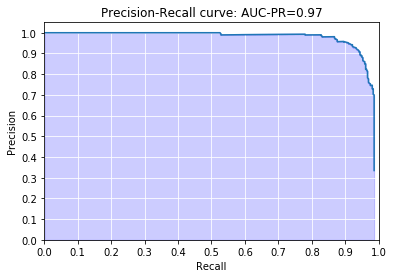

In [69]:
plot_precision_recall(precision=precision, recall=recall)

--- 10.06.2020